#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import bootcampviztools as bt
import statsmodels.api as sm
import warnings
import sklearn
import os
import cv2
import re


from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score, silhouette_samples, mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, scale
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from scipy import stats
from scipy.stats import mannwhitneyu


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor


warnings.filterwarnings('ignore')
style.use('ggplot') or plt.style.use('ggplot')

## Data

In [78]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
pcs = pd.read_csv("./data/train.csv")

## Data exploration

In [79]:
pcs.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [80]:
pcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [81]:
# No hay nulos, bien!
# numéricas hay apenas 4 (las 2 de IF, las inches y el precio, que es el target)
# Tenemos una gran parte de variables categóricas que habrá que procesar y transformar en numéricas

In [82]:
pcs.describe()

,id,laptop_ID,Inches,Price_euros
count,912.000000,912.000000,912.000000,912.000000
mean,645.091009,666.192982,15.011404,1108.122873
std,380.313813,384.873846,1.411744,714.597741
min,0.000000,1.000000,10.100000,174.000000
25%,319.750000,330.500000,14.000000,589.000000
50%,636.500000,673.500000,15.600000,949.000000
75%,980.250000,998.500000,15.600000,1458.500000
max,1302.000000,1320.000000,18.400000,6099.000000


In [83]:
target = "Price_euros"

In [84]:
pcs["Company"].value_counts()

Company
Lenovo       208
Dell         207
HP           189
Asus         108
Acer          75
Toshiba       37
MSI           34
Apple         17
Mediacom       7
Razer          6
Samsung        6
Fujitsu        3
Microsoft      3
Vero           3
Xiaomi         3
Google         2
Chuwi          2
LG             1
Huawei         1
Name: count, dtype: int64

In [85]:
pcs["Product"].value_counts()

Product
Inspiron 3567                                21
XPS 13                                       20
250 G6                                       19
Vostro 3568                                  16
Inspiron 5570                                11
                                             ..
Elitebook Folio                               1
Q304UA-BHI5T11 (i5-7200U/6GB/1TB/FHD/W10)     1
ThinkPad T470p                                1
V310-15IKB (i5-7200U/4GB/1TB/No               1
Portege Z30-C-16H                             1
Name: count, Length: 475, dtype: int64

In [86]:
pcs["Product"].value_counts().unique()

array([21, 20, 19, 16, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

In [87]:
pcs["TypeName"].value_counts()

TypeName
Notebook              522
Gaming                138
Ultrabook             135
2 in 1 Convertible     85
Workstation            18
Netbook                14
Name: count, dtype: int64

In [88]:
pcs["Inches"].value_counts()

Inches
15.6    474
14.0    143
13.3    111
17.3    108
12.5     28
11.6     21
12.0      6
10.1      4
13.9      4
15.4      3
15.0      3
13.5      3
12.3      2
13.0      1
18.4      1
Name: count, dtype: int64

<Axes: >

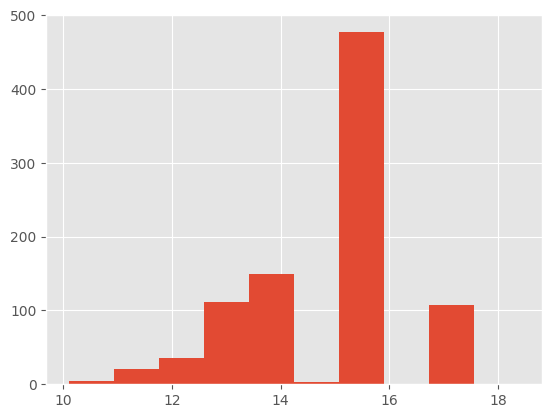

In [89]:
pcs["Inches"].hist()

In [90]:
pcs["ScreenResolution"].value_counts()

ScreenResolution
Full HD 1920x1080                                346
1366x768                                         208
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         37
Full HD / Touchscreen 1920x1080                   32
Touchscreen 1366x768                              15
1600x900                                          11
IPS Panel 4K Ultra HD 3840x2160                   10
4K Ultra HD / Touchscreen 3840x2160                8
Quad HD+ / Touchscreen 3200x1800                   8
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      8
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 5
IPS Panel 1366x768                                 5
4K Ultra HD 3840x2160                              5
IPS Panel Touchscreen 1920x1200                    4
Touchscreen 2560x1440                              4
IPS Panel Quad HD+ / Touchscreen 3200x1800         4
IPS Panel Touchscreen 2560x14

In [91]:
pcs["Cpu"].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     142
Intel Core i7 7700HQ 2.8GHz    102
Intel Core i7 7500U 2.7GHz      88
Intel Core i5 8250U 1.6GHz      54
Intel Core i5 6200U 2.3GHz      51
                              ... 
Intel Core i7 7660U 2.5GHz       1
AMD E-Series E2-9000 2.2GHz      1
Intel Core i3 6006U 2.2GHz       1
Intel Core i7 2.8GHz             1
AMD E-Series 9000 2.2GHz         1
Name: count, Length: 104, dtype: int64

In [92]:
pcs["Cpu"].unique()

array(['Intel Core i7 7500U 2.7GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 6300U 2.4GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i7 8550U 1.8GHz', 'AMD A9-Series A9-9420 3GHz',
       'Intel Pentium Dual Core 4405U 2.1GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Xeon E3-1535M v6 3.1GHz',
       'Intel Atom x5-Z8550 1.44GHz', 'AMD A10-Series 9620P 2.5GHz',
       'Intel Core i5 7300U 2.6GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i3 6006U 2.0GHz',
       'Intel Celeron Dual Core 3205U 1.5GHz',
       'AMD A12-Series 9720P 3.6GHz',
       'Intel Celeron Dual Core N3050 1.6GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Core i5 7200U 2.7GHz', 'Intel Core i7 7820HQ 2.9GHz

In [93]:
pcs["Ram"].value_counts()

Ram
8GB     434
4GB     274
16GB    125
6GB      32
2GB      16
12GB     15
32GB     14
24GB      2
Name: count, dtype: int64

In [94]:
pcs["Memory"].value_counts()

Memory
256GB SSD                        293
1TB HDD                          150
500GB HDD                        100
512GB SSD                         75
128GB SSD +  1TB HDD              61
128GB SSD                         56
256GB SSD +  1TB HDD              52
32GB Flash Storage                27
64GB Flash Storage                11
2TB HDD                           11
512GB SSD +  1TB HDD              10
1TB SSD                            9
1.0TB Hybrid                       7
256GB Flash Storage                7
32GB SSD                           5
180GB SSD                          5
256GB SSD +  2TB HDD               4
16GB Flash Storage                 4
16GB SSD                           3
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
128GB Flash Storage                2
512GB SSD +  2TB HDD               2
512GB Flash Storage                2
1.0TB HDD                          1
32GB HDD                           1
128GB SSD +  2TB HDD           

In [95]:
pcs["Gpu"].value_counts()

Gpu
Intel HD Graphics 620      199
Intel HD Graphics 520      138
Intel UHD Graphics 620      45
Nvidia GeForce GTX 1050     43
Nvidia GeForce GTX 1060     31
                          ... 
Nvidia GeForce 920MX         1
Intel HD Graphics 620        1
AMD Radeon R7 M365X          1
Nvidia Quadro M2200M         1
Nvidia Quadro M520M          1
Name: count, Length: 91, dtype: int64

In [96]:
pcs["OpSys"].value_counts()

OpSys
Windows 10      746
Linux            47
No OS            44
Windows 7        32
Chrome OS        20
macOS            11
Mac OS X          6
Windows 10 S      4
Android           2
Name: count, dtype: int64

In [97]:
pcs["Weight"].value_counts()

Weight
2.2kg     86
2.1kg     40
2.3kg     35
2.4kg     31
2kg       30
          ..
4.0kg      1
0.98kg     1
3.6kg      1
2.99kg     1
1.79kg     1
Name: count, Length: 158, dtype: int64

## Data processing

In [98]:
# Separación train y test

In [99]:
var_desc = ["laptop_ID", "Product"] 
pcs = pcs.drop(["laptop_ID", "Product"], axis=1) 

X = pcs.drop("Price_euros", axis=1) 
y = pcs["Price_euros"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [100]:
len(X_train)

729

In [101]:
len(X_test)

183

### Mini EDA

In [102]:
pcs_eda = pd.concat([X_train, y_train], axis=1)

target = "Price_euros"
var_categ = []
var_num = [] 
var_sec = []

In [103]:
# Para inches solo comprobamos que sea nummérica
pcs_eda['Inches'] = pcs_eda['Inches'].astype(float)
var_num.append("Inches")

In [104]:
var_categ.append("OpSys")
var_categ.append("TypeName")

In [105]:
# Primero tenemos que hacer unas ligeras transformaciones para que las columnas tengan el tipo de valor que necesitamos, sea categórico, numérico, etc

In [106]:
# Transformar la columna 'Company'
marcas_ppales = pcs_eda['Company'].value_counts().sort_values(ascending=False) / pcs_eda['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs_eda['Company'].unique() if company not in top_10_companies]
pcs_eda['Company'] = pcs_eda['Company'].replace(otras_marcas, "Otra")
var_categ.append("Company")

In [107]:
# Transformar la columna 'Weight'
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: float(x.replace('kg', '').replace(',', '.')))
var_num.append("Weight")

In [108]:
# Transformar la columna 'Ram'
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))
var_num.append("Ram")

In [109]:
# Y las que hay que procesar un poco más: 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', de las quw voy a sacar varias columnas, sean categóricas o numéricas

In [110]:
# Transformar la columna 'ScreenResolution'
def extract_screen_resolution(df):  # Modificar la definición de la función
    global num_cols  # Acceder a num_cols como variable global
    # Aplicar la función para extraer la resolución de la pantalla y crear la nueva columna 'SCR_resol'
    df['SCR_resol'] = df['ScreenResolution'].apply(extract_resolution)
    num_cols.append("SCR_resol")  # Agregar 'SCR_resol' a las columnas numéricas
    # Lista de etiquetas de características de pantalla
    labels = ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']
    # Agregar características de pantalla como columnas binarias
    for label in labels:
        df[label] = df['ScreenResolution'].apply(lambda x: 1 if label in x else 0)
    return df

# Verificar si 'SCR_FullHD' está presente en el DataFrame pcs_eda
print('SCR_FullHD' in pcs_eda.columns)

False


In [111]:
# Transformar la columna 'Cpu'
def extract_cpu_info(cpu):
    brand_pattern = r'(Intel|AMD)'
    speed_pattern = r'(\d+\.\d+)GHz'
    model_pattern = r'\b(?:Core [iI]\d+|Ryzen \d+)\b'
    series_pattern = r'(?:Intel|AMD)(.*?)\b(?:Core [iI]\d+|Ryzen \d+|$)'

    brand_match = re.search(brand_pattern, cpu)
    brand = brand_match.group(1) if brand_match else None

    speed_match = re.search(speed_pattern, cpu)
    speed = float(speed_match.group(1)) if speed_match else None

    model_match = re.search(model_pattern, cpu)
    model = model_match.group() if model_match else None

    series_match = re.search(series_pattern, cpu)
    series = series_match.group(1).strip() if series_match else None

    return brand, speed, model, series

pcs_eda['CPU_marca'], pcs_eda['CPU_velocidad'], pcs_eda['CPU_modelo'], pcs_eda['CPU_serie'] = zip(*pcs_eda['Cpu'].apply(extract_cpu_info))
var_categ.append("CPU_marca")
var_num.append("CPU_velocidad")
var_categ.append("CPU_modelo")
var_categ.append("CPU_serie")


In [112]:
# Transformar la columna 'Memory'
def extract_memory_info(memory):
    memory_pattern = r'(\d+)\s*(?:GB|T|TB)'
    keyword_pattern = r'HDD|SSD|Flash Storage|Hybrid'

    match = re.findall(memory_pattern, memory)
    if match:
        memory_value = int(match[0][0]) * 1024 if 'T' in memory else int(match[0][0])
    else:
        memory_value = 0

    keywords = re.findall(keyword_pattern, memory)
    storage_dict = {'HDD': 0, 'SSD': 0, 'Flash Storage': 0, 'Hybrid': 0}
    for keyword in keywords:
        storage_dict[keyword] = memory_value

    return storage_dict['HDD'], storage_dict['SSD'], storage_dict['Flash Storage'], storage_dict['Hybrid']

pcs_eda['Memo_HDD'], pcs_eda['Memo_SSD'], pcs_eda['Memo_Flash'], pcs_eda['Memo_Hybrid'] = zip(*pcs_eda['Memory'].apply(extract_memory_info))
pcs_eda.rename(columns={'Memo_HDD': 'Memo_HDD_GB', 'Memo_SSD': 'Memo_SSD_GB', 'Memo_Flash': 'Memo_Flash_GB', 'Memo_Hybrid': 'Memo_Hybrid_GB'}, inplace=True)
var_num.append("Memo_HDD_GB")
var_num.append("Memo_SSD_GB")
var_num.append("Memo_Flash_GB")
var_num.append("Memo_Hybrid_GB")

In [113]:
# Transformar la columna 'Gpu'
def extract_gpu_info(gpu):
    gpu_parts = gpu.split()
    gpu_brand = gpu_parts[0]
    gpu_model = None
    for part in gpu_parts:
        if any(char.isdigit() for char in part):
            gpu_model = ''.join(filter(str.isdigit, part))
            break
    gpu_family = ' '.join(gpu_parts[1:]) if gpu_model else ' '.join(gpu_parts[1:])
    return gpu_brand, gpu_model, gpu_family

pcs_eda['GPU_marca'], pcs_eda['GPU_modelo'], pcs_eda['GPU_familia'] = zip(*pcs_eda['Gpu'].apply(extract_gpu_info))
var_categ.append("GPU_marca")
var_num.append("GPU_modelo")
var_categ.append("GPU_familia")

In [114]:
# A ver la distribución de las numéricas

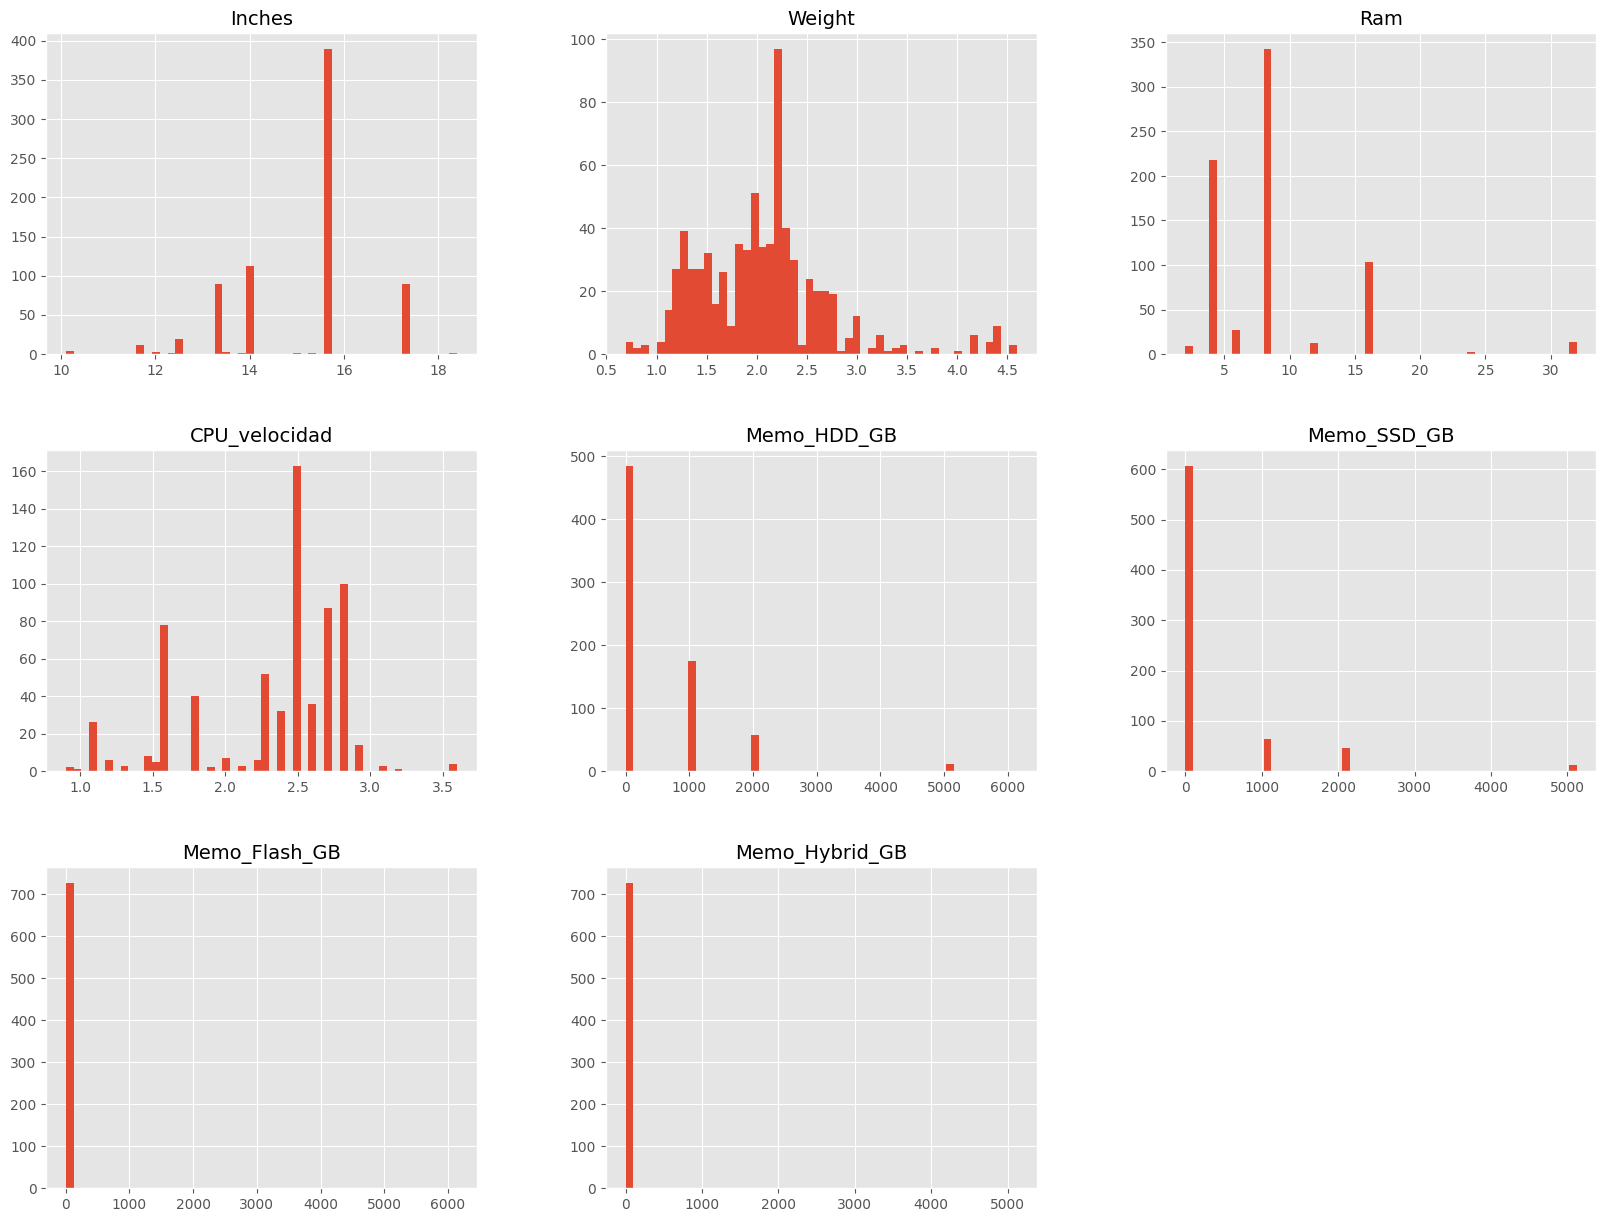

In [115]:
# Configurar las opciones de visualización
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Histogramas de las variables numéricas
pcs_eda[var_num].hist(bins=50, figsize=(20, 15))
plt.show()

(2,)


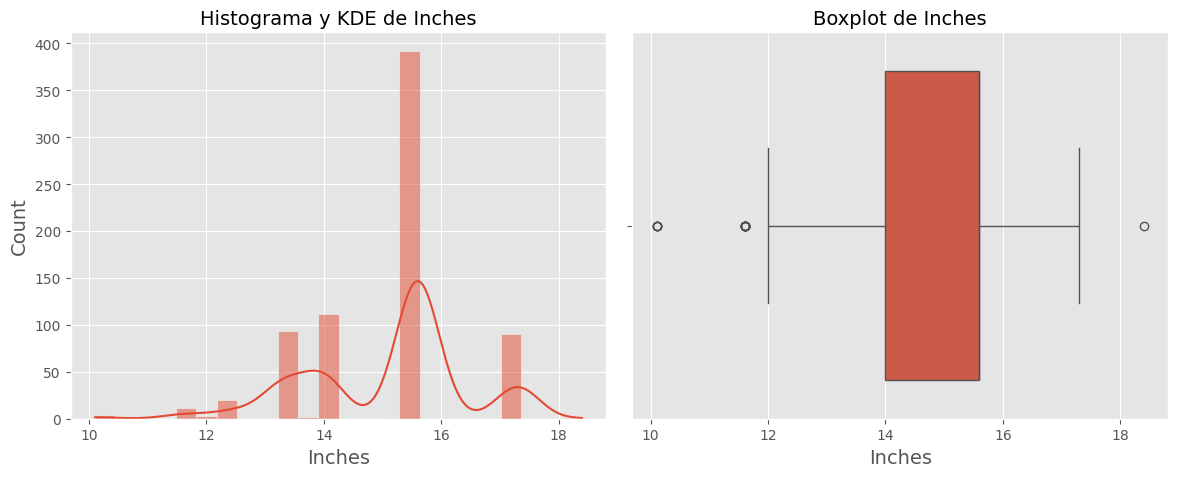

In [116]:
# Y a ver si hay outliers, y los quito

bt.plot_combined_graphs(X_train, ["Inches"])

(2,)


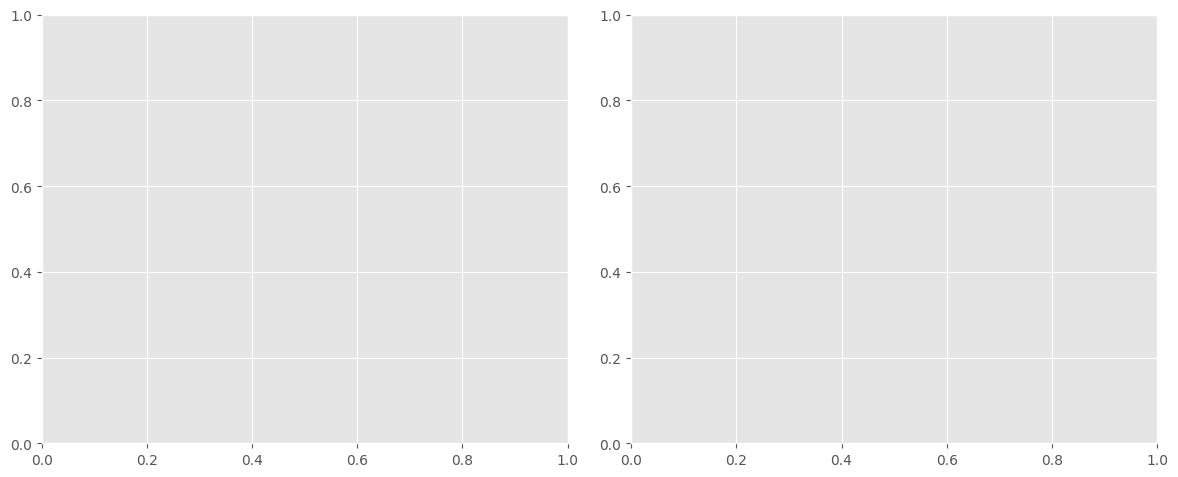

In [117]:
# Y a ver si hay outliers
bt.plot_combined_graphs(X_train, ["Weight"])

In [118]:
numeric_cols = pcs_eda.select_dtypes(include=np.number)

# Calcular el rango intercuartílico solo para las columnas numéricas
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Definir un límite para considerar outliers solo para las columnas numéricas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Eliminar outliers solo para las columnas numéricas
pcs_eda_no_outliers = pcs_eda[(numeric_cols >= lower_bound) & (numeric_cols <= upper_bound)].dropna()

In [119]:
var_fuera = []
cardinality = pcs_eda.select_dtypes(include='object').nunique()

# Definir un umbral para la cardinalidad (por ejemplo, 10)
umbral_cardinalidad = 15

# Identificar las columnas categóricas con una cardinalidad alta
columnas_alta_cardinalidad = cardinality[cardinality > umbral_cardinalidad].index.tolist()

# Mover las columnas con alta cardinalidad a var_fuera y eliminarlas del DataFrame principal
var_fuera.append(columnas_alta_cardinalidad)
pcs_eda.drop(columns=columnas_alta_cardinalidad, inplace=True)

In [120]:
columnas_categoricas = pcs_eda.select_dtypes(include='object').columns

# Aplicar get_dummies a las columnas categóricas seleccionadas
pcs_eda_encoded = pd.get_dummies(pcs_eda, columns=columnas_categoricas, drop_first=True)

In [121]:
print(pcs_eda_encoded.dtypes)
print(pcs_eda_encoded.columns)

id                         int64
Inches                   float64
Ram                        int64
Weight                   float64
Price_euros              float64
CPU_velocidad            float64
Memo_HDD_GB                int64
Memo_SSD_GB                int64
Memo_Flash_GB              int64
Memo_Hybrid_GB             int64
Company_Apple               bool
Company_Asus                bool
Company_Dell                bool
Company_HP                  bool
Company_Lenovo              bool
Company_MSI                 bool
Company_Otra                bool
Company_Toshiba             bool
TypeName_Gaming             bool
TypeName_Netbook            bool
TypeName_Notebook           bool
TypeName_Ultrabook          bool
TypeName_Workstation        bool
OpSys_Chrome OS             bool
OpSys_Linux                 bool
OpSys_Mac OS X              bool
OpSys_No OS                 bool
OpSys_Windows 10            bool
OpSys_Windows 10 S          bool
OpSys_Windows 7             bool
OpSys_macO

In [122]:
var_fuera

[['ScreenResolution',
  'Cpu',
  'Memory',
  'Gpu',
  'CPU_serie',
  'GPU_modelo',
  'GPU_familia']]

In [123]:
var_categ

['OpSys',
 'TypeName',
 'Company',
 'CPU_marca',
 'CPU_modelo',
 'CPU_serie',
 'GPU_marca',
 'GPU_familia']

In [124]:
# Seleccionar solo las columnas numéricas que quedan en pcs_eda
columnas_numericas = pcs_eda.select_dtypes(include=['int', 'float']).columns

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Escalar las columnas numéricas seleccionadas
pcs_eda[columnas_numericas] = scaler.fit_transform(pcs_eda[columnas_numericas])

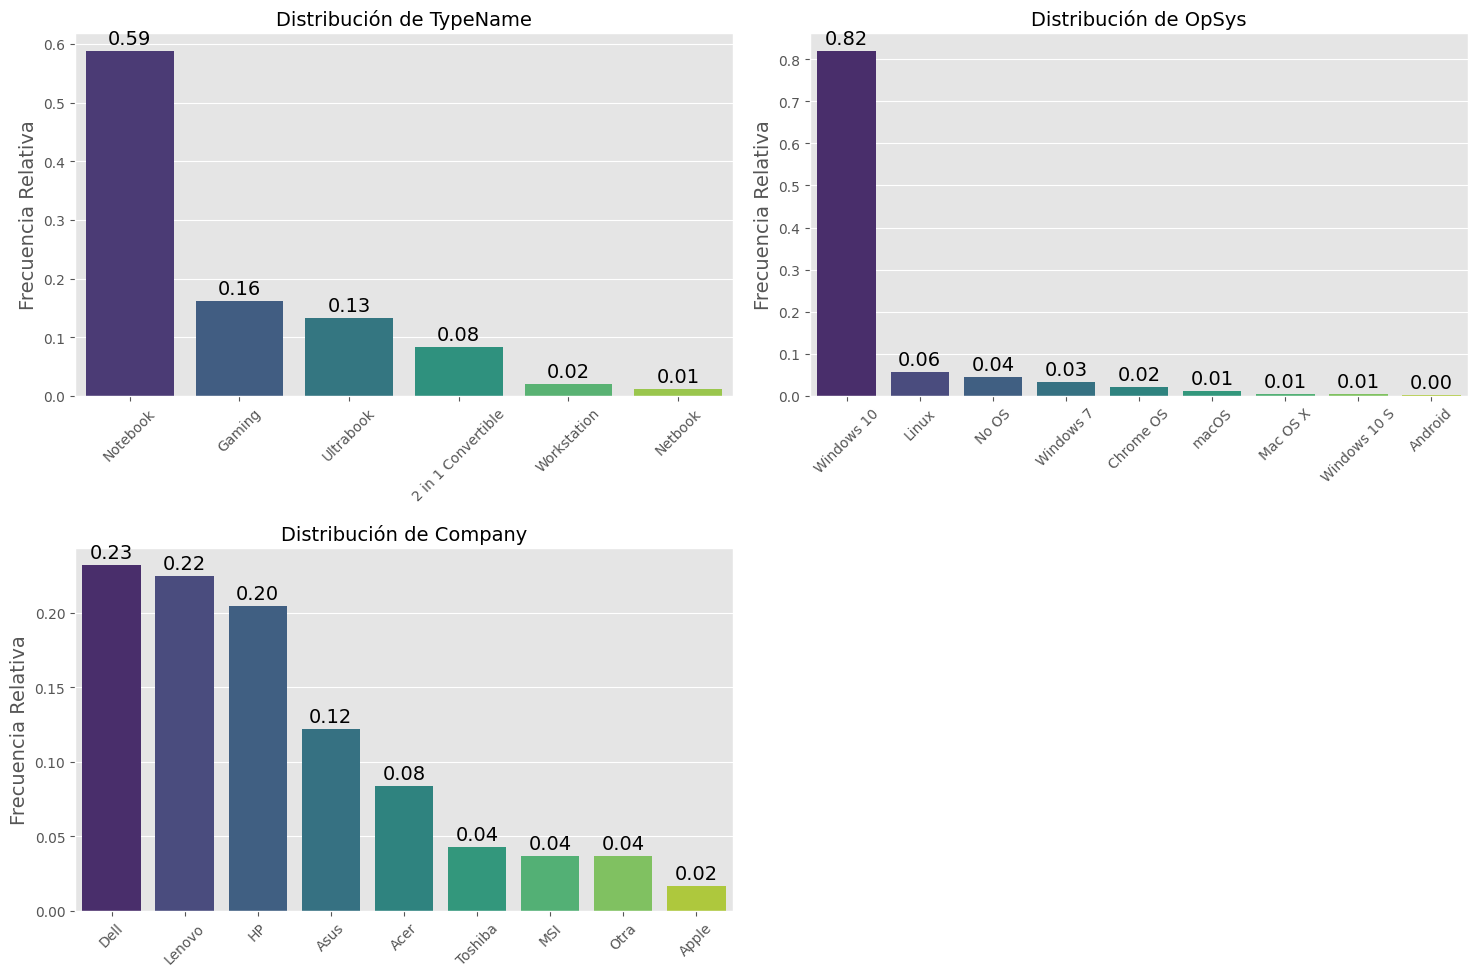

In [125]:
# A ver la frecuencia de las categóricas
bt.pinta_distribucion_categoricas(pcs_eda, ['TypeName',
 'OpSys',
 'Company'], relativa= True, mostrar_valores= True)

In [126]:
# Vamos ahora al análisis bivaruante, primero de las categóricas, una por una contra el target 

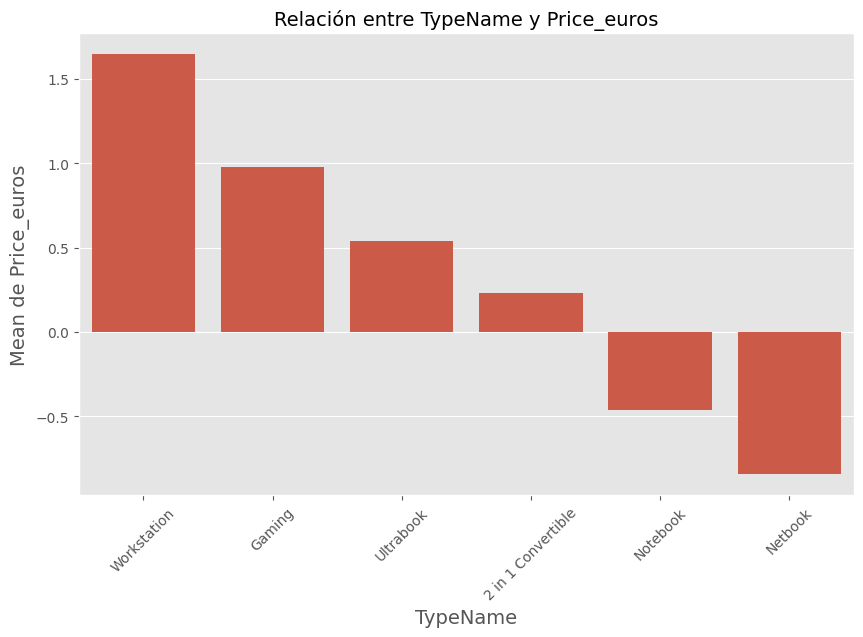

In [127]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "TypeName", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("TypeName")

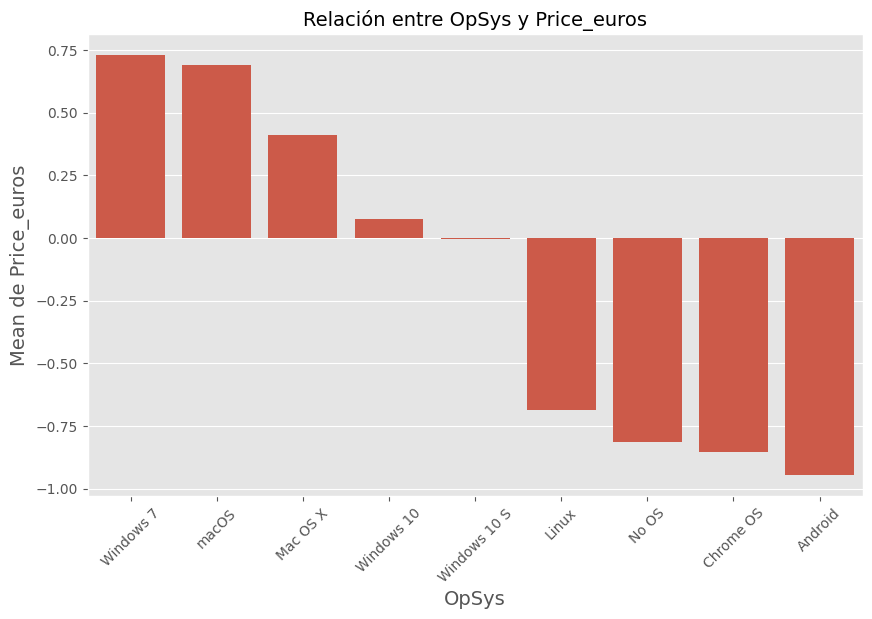

In [128]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "OpSys", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("OpSys")

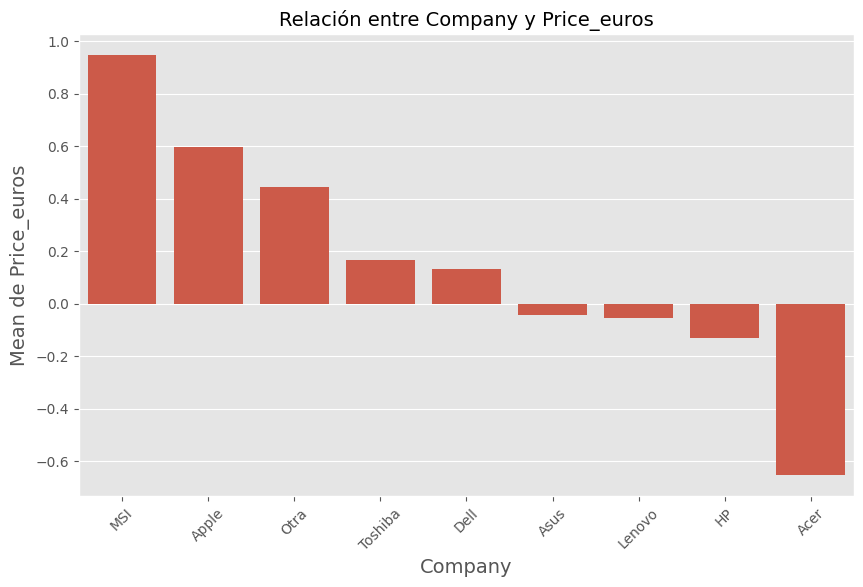

In [129]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "Company", numerical_col="Price_euros")
# a primera vista esta variable nos interesa, aunque es más plana que las otras. Al final me las he quedado todas
var_categ.append("Company")
# tal vez debería hilar más fino en Company a la hora de agrupar en Otras, para que no quede algo tan masivo?

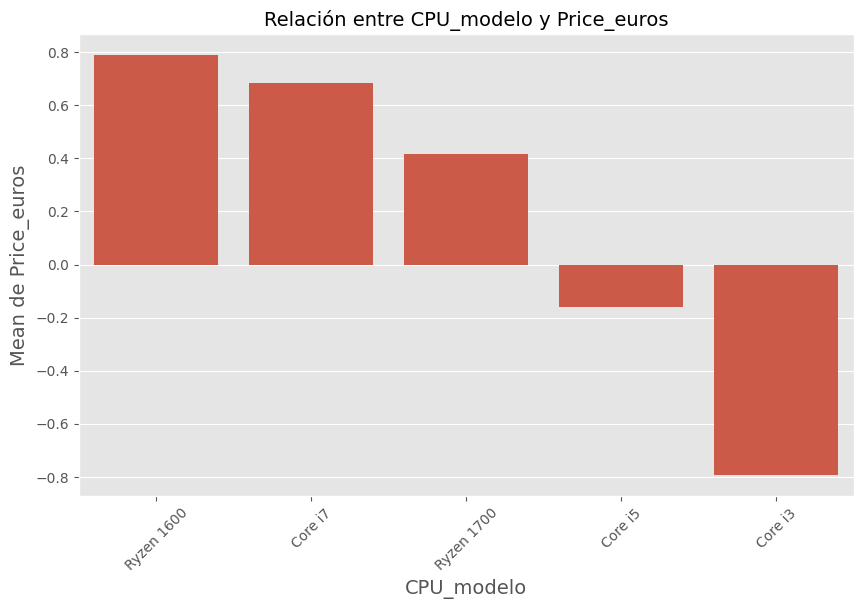

In [130]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "CPU_modelo", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("CPU_modelo")

In [131]:
# bt.plot_<ategorical_numerical_relationship(pcs_eda, categorical_col= "GPU_familia", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_desc.append("GPU_familia")

# La familia así no la voy a hacer. Necesitaría reducir la cantidad de variables, ahora mismo no sé cómo agrupar habida cuenta la gran dispersión....

In [132]:
# bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "CPU_serie", numerical_col="Price_euros")
# a primera vista esta variable tiene una gran dispersión, la descarto
var_desc.append("CPU_serie")

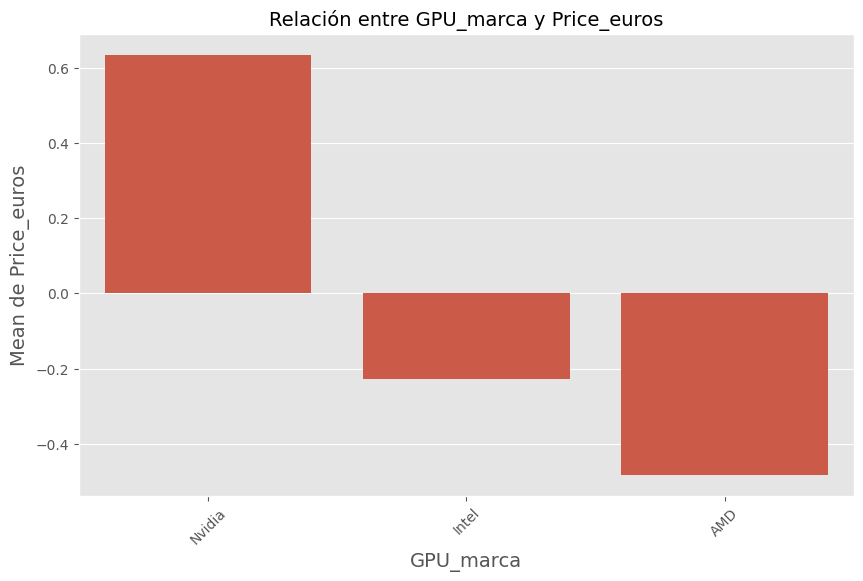

In [133]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "GPU_marca", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("GPU_marca")

In [134]:
# Analicemos ahora target vs las Numéricas
# queda pendiente... que lo haga solo

In [135]:
#Acá sería lo que me suele faltar del histograma??.... sí, en el análisis manual, sí, pero esta vez me lo salto

In [136]:
# Selección de features

In [137]:
pcs_eda.corr(numeric_only= True) 

,id,Inches,Ram,Weight,Price_euros,CPU_velocidad,Memo_HDD_GB,Memo_SSD_GB,Memo_Flash_GB,Memo_Hybrid_GB
id,1.000000,0.038052,-0.021972,0.053836,-0.012153,0.044151,0.030054,0.017816,-0.039252,-0.060369
Inches,0.038052,1.000000,0.265210,0.826690,0.106196,0.297599,0.435477,0.358006,0.012729,0.077781
Ram,-0.021972,0.265210,1.000000,0.447989,0.754267,0.370262,0.383043,0.544880,-0.003280,0.179068
Weight,0.053836,0.826690,0.447989,1.000000,0.287637,0.329093,0.540878,0.548809,0.008493,0.184056
Price_euros,-0.012153,0.106196,0.754267,0.287637,1.000000,0.432049,0.213434,0.433531,0.043679,0.131108
CPU_velocidad,0.044151,0.297599,0.370262,0.329093,0.432049,1.000000,0.220789,0.254913,-0.397444,0.037347
Memo_HDD_GB,0.030054,0.435477,0.383043,0.540878,0.213434,0.220789,1.000000,0.796875,0.236004,-0.026777
Memo_SSD_GB,0.017816,0.358006,0.544880,0.548809,0.433531,0.254913,0.796875,1.000000,-0.013865,0.226941
Memo_Flash_GB,-0.039252,0.012729,-0.003280,0.008493,0.043679,-0.397444,0.236004,-0.013865,1.000000,-0.001826
Memo_Hybrid_GB,-0.060369,0.077781,0.179068,0.184056,0.131108,0.037347,-0.026777,0.226941,-0.001826,1.000000


In [138]:
corr_matrix = pcs_eda.corr(numeric_only= True) 
corr_matrix["Price_euros"].sort_values(ascending = False)

# el id evidentemente no tiene ninguna influencia en el precio y RAM la tomo como categ.

Price_euros       1.000000
Ram               0.754267
Memo_SSD_GB       0.433531
CPU_velocidad     0.432049
Weight            0.287637
Memo_HDD_GB       0.213434
Memo_Hybrid_GB    0.131108
Inches            0.106196
Memo_Flash_GB     0.043679
id               -0.012153
Name: Price_euros, dtype: float64

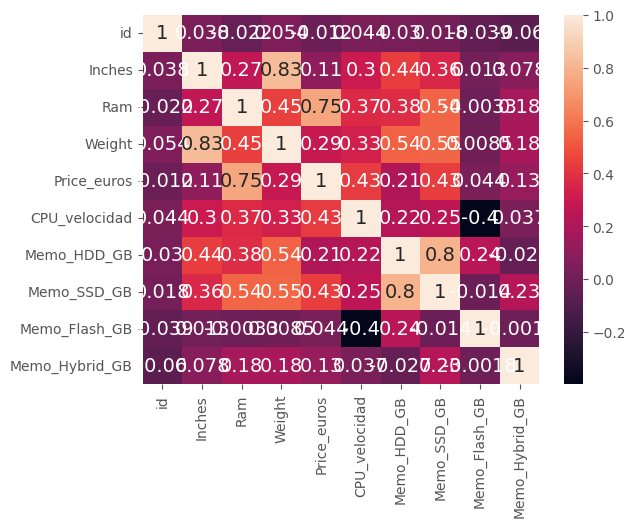

In [139]:
sns.heatmap(pcs_eda.corr(numeric_only = True),annot=True);
plt.show();

In [140]:
var_num

['Inches',
 'Weight',
 'Ram',
 'CPU_velocidad',
 'Memo_HDD_GB',
 'Memo_SSD_GB',
 'Memo_Flash_GB',
 'Memo_Hybrid_GB',
 'GPU_modelo']

In [141]:
columnas = corr_matrix["Price_euros"][corr_matrix["Price_euros"] > 0.07].index.to_list() 
columnas

['Inches',
 'Ram',
 'Weight',
 'Price_euros',
 'CPU_velocidad',
 'Memo_HDD_GB',
 'Memo_SSD_GB',
 'Memo_Hybrid_GB']

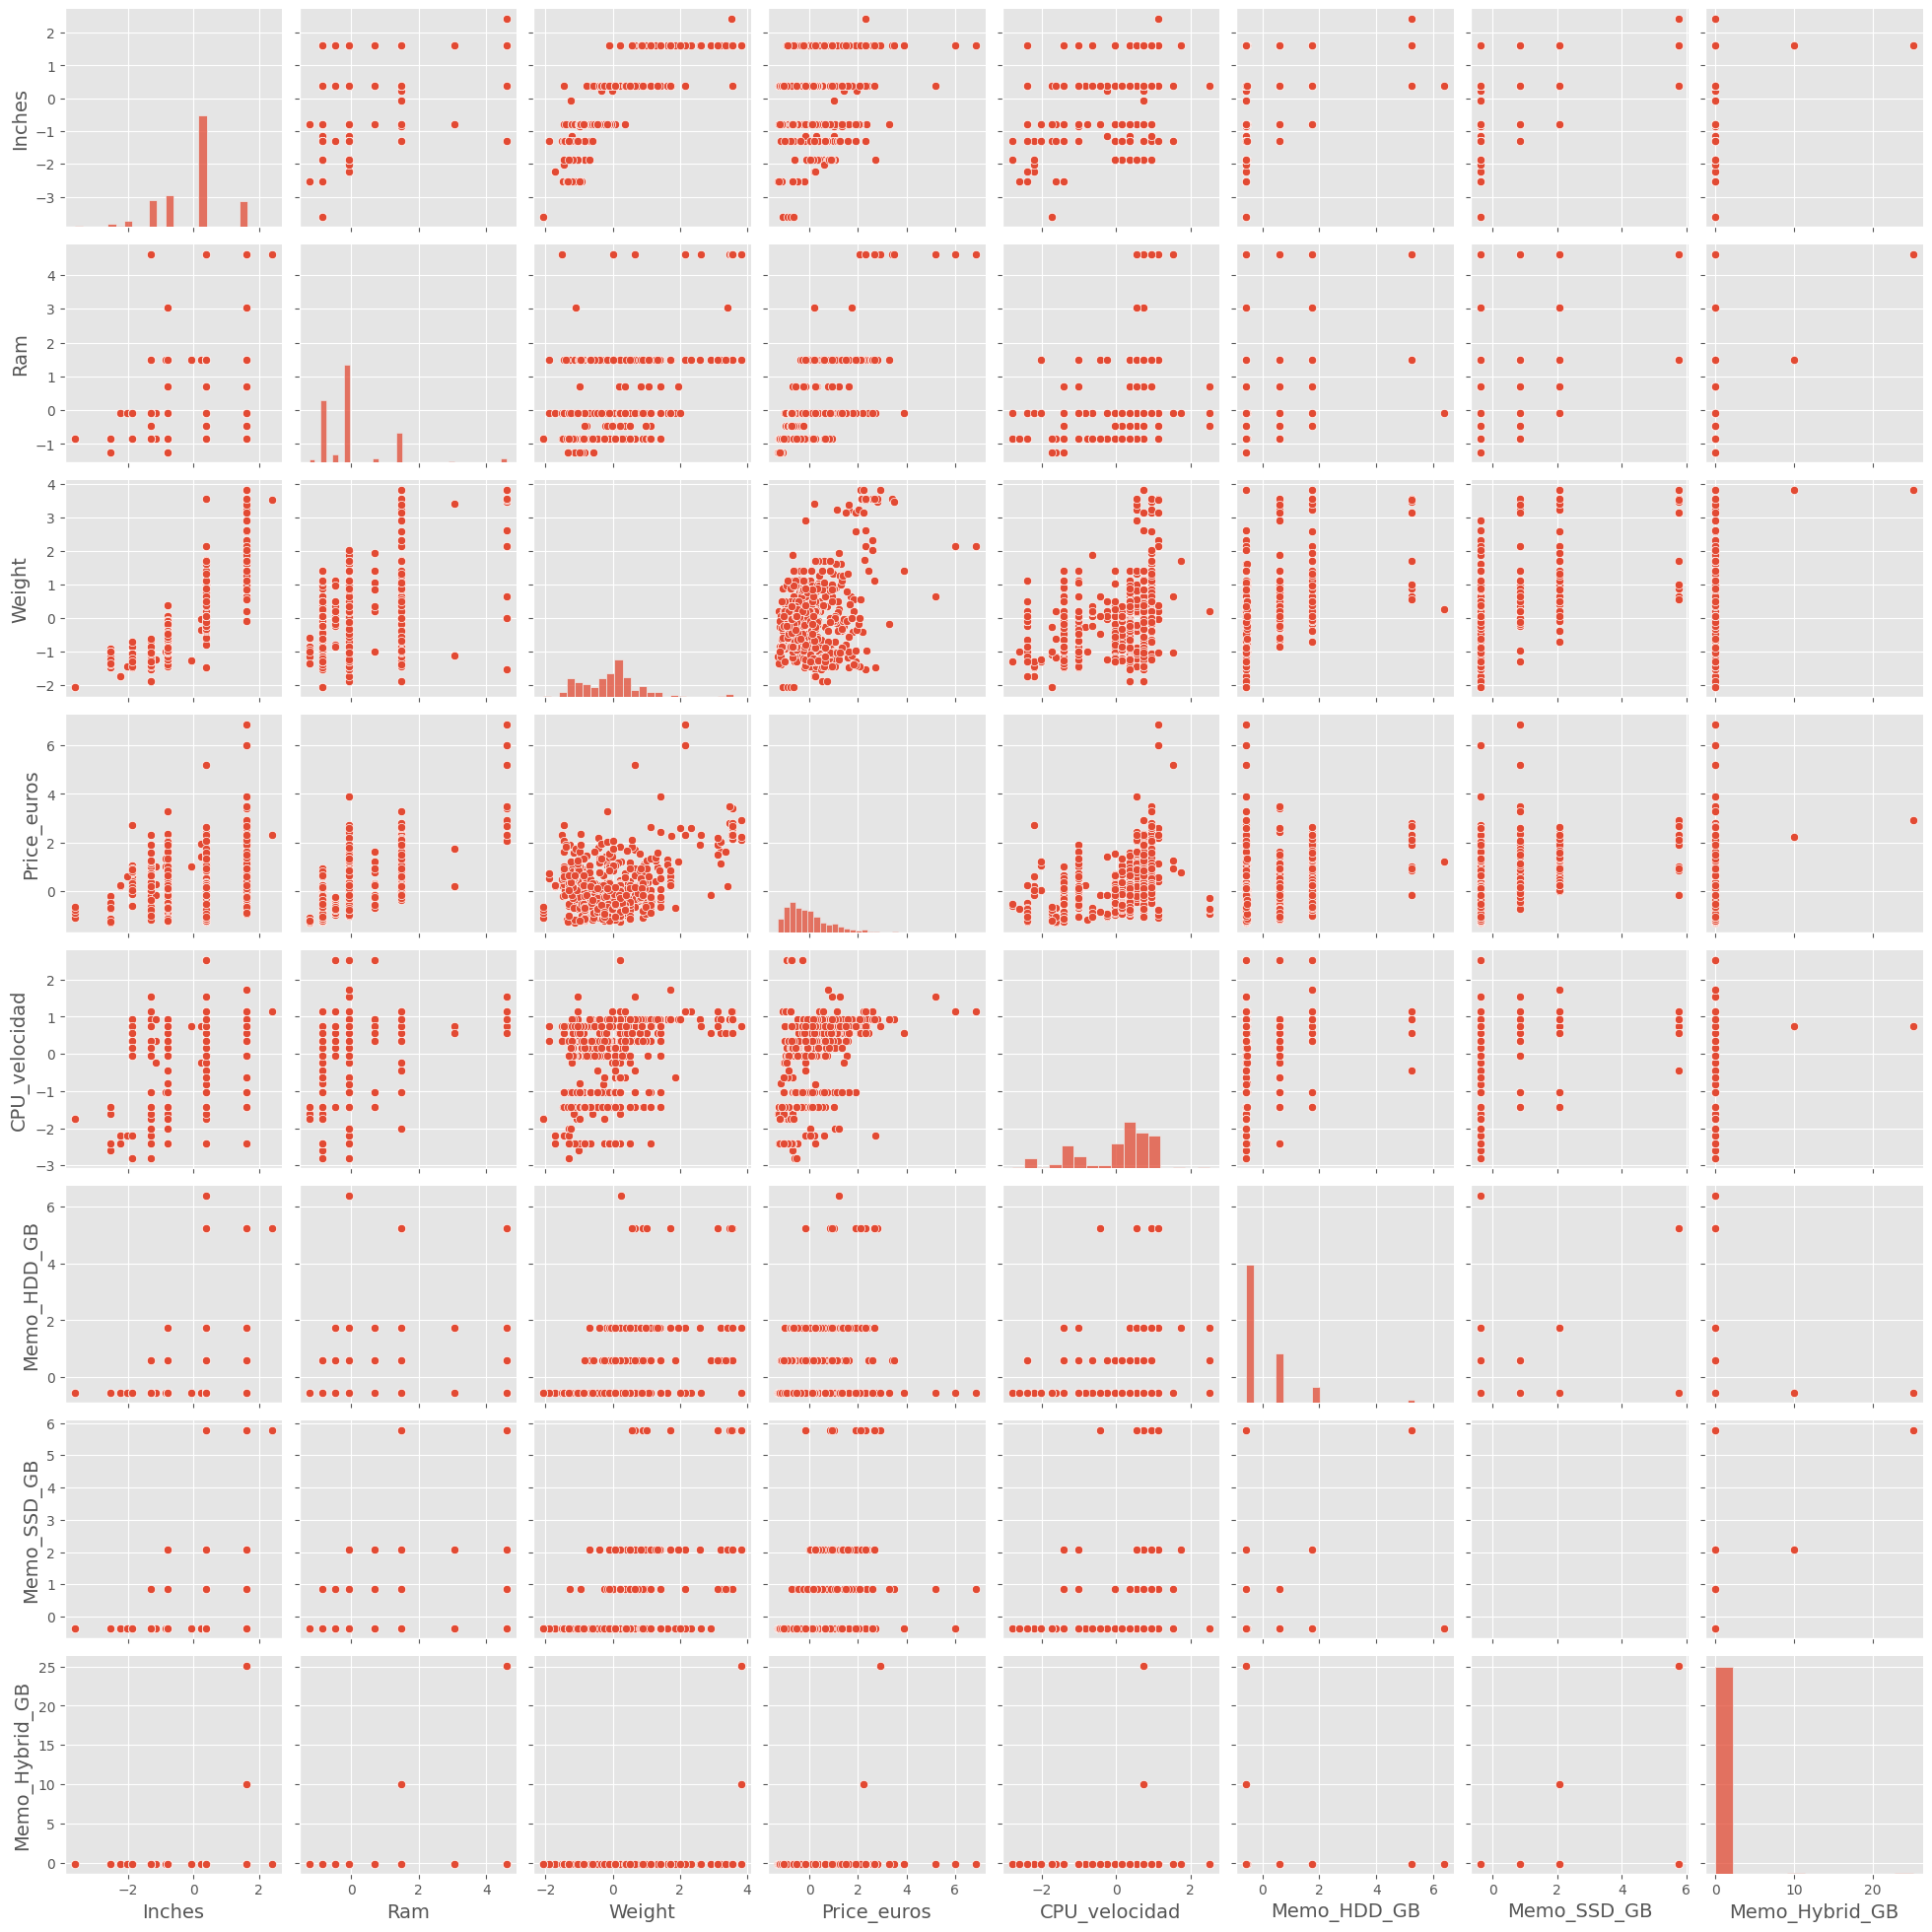

In [142]:
sns.pairplot(pcs_eda[columnas]);
# no tiene ningún sentido...

In [143]:
# Elegir cuáles quedan, cuáles se descartan, cuáles son secundarios.... Fin del EDA
columnas_numericas = columnas
columnas_categoricas = var_categ

In [144]:
# seleccion FALTAAAAA.... bah, esta vez no la hago, la hará el propio modelo

In [145]:
X_train = pcs_eda.drop(columns=[target])
y_train = pcs_eda[target]

In [146]:
# Le tengo que aplicar los mismos cambios a X_test (y después al df de prueba definitiva)

# Función para convertir una columna a tipo float
def convert_to_float(df, col):
    df[col] = df[col].astype(float)
    return df

# Función para agrupar marcas principales y renombrar el resto como "Otra" solo para la columna 'Company'
def group_top_brands_company(df, threshold=0.01):
    value_counts = df['Company'].value_counts(normalize=True)
    top_brands = value_counts[value_counts >= threshold].index.tolist()
    other_brands = [brand for brand in df['Company'].unique() if brand not in top_brands]
    df['Company'] = df['Company'].replace(other_brands, "Otra")
    return df

# Función para eliminar outliers
def remove_outliers(df, num_cols):
    # Calcular el rango intercuartílico solo para las columnas numéricas
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Definir un límite para considerar outliers solo para las columnas numéricas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Eliminar outliers solo para las columnas numéricas
    df_no_outliers = df[(df[num_cols] >= lower_bound) & (df[num_cols] <= upper_bound)].dropna()

    return df_no_outliers

# Función para crear variables dummy para las variables categóricas
def create_dummies(df, cat_cols):
    # Tu código para crear variables dummy aquí
    return df

# Función para escalar las variables numéricas
def scale_numeric(df, num_cols):
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Función para aplicar todas las transformaciones
def preprocess_data(df):   
    
    # Eliminar las columnas var_desc si están presentes
    var_desc = ["laptop_ID", "Product"]
    if all(col in df.columns for col in var_desc):
        df = df.drop(var_desc, axis=1)

    # Convertir 'Weight' a tipo float
    df['Weight'] = df['Weight'].apply(lambda x: float(x.replace('kg', '').replace(',', '.')))  
    
    # Convertir 'Ram' a tipo int
    df['Ram'] = df['Ram'].apply(lambda x: int(x.replace('GB', '')))  
    
    # Convertir la columna 'Inches' a tipo float
    df = convert_to_float(df, 'Inches')  
    
    # Agrupar marcas principales y renombrar el resto como "Otra" solo para la columna 'Company'
    df = group_top_brands_company(df)  
    
    # Detectar columnas categóricas y numéricas automáticamente
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Aplicar transformación específica para 'ScreenResolution' antes de escalar
    df = extract_screen_resolution(df, num_cols)  
    
    # Extraer información de la CPU
    df['CPU_marca'], df['CPU_velocidad'], df['CPU_modelo'], df['CPU_serie'] = zip(*df['Cpu'].apply(extract_cpu_info))
    
    # Extraer información de la memoria
    df['Memo_HDD'], df['Memo_SSD'], df['Memo_Flash'], df['Memo_Hybrid'] = zip(*df['Memory'].apply(extract_memory_info))
    
    # Extraer información de la GPU
    df['GPU_marca'], df['GPU_modelo'], df['GPU_familia'] = zip(*df['Gpu'].apply(extract_gpu_info))

    # Eliminar outliers
    df = remove_outliers(df, num_cols) 
    
    # Eliminar columnas con alta cardinalidad y aplicar get_dummies a las restantes
    cardinality = df.select_dtypes(include='object').nunique()
    umbral_cardinalidad = 15
    columnas_alta_cardinalidad = cardinality[cardinality > umbral_cardinalidad].index.tolist()
    df.drop(columns=columnas_alta_cardinalidad, inplace=True)
    df_encoded = pd.get_dummies(df, columns=df.select_dtypes(include='object').columns, drop_first=True)
    
    # Escalar columnas numéricas
    df = scale_numeric(df_encoded, num_cols)

    # Incorporar transformaciones adicionales
    df['Ram'] = df['Ram'].astype('int64')
    df = pd.get_dummies(df, columns=['Company', 'TypeName', 'OpSys', 'CPU_marca', 'CPU_modelo', 'GPU_marca'], drop_first=True)

    
    return df

In [147]:
print(X_train.dtypes)
print(y_train.dtype)

id                float64
Company            object
TypeName           object
Inches            float64
Ram               float64
OpSys              object
Weight            float64
CPU_marca          object
CPU_velocidad     float64
CPU_modelo         object
Memo_HDD_GB       float64
Memo_SSD_GB       float64
Memo_Flash_GB     float64
Memo_Hybrid_GB    float64
GPU_marca          object
dtype: object
float64


# Modelo

In [148]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state= 42)
rf_reg = RandomForestRegressor(random_state= 42)
xgb_reg = XGBRegressor(random_state = 42)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100)
cat_reg = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_reg, tree_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]

In [149]:
X_train_encoded = pd.get_dummies(X_train)

# 2. Asegurarse de que y_train sea un array NumPy de una dimensión
y_train_array = y_train.values.ravel()

# 3. Asegurarse de que y_train no contenga valores faltantes o no numéricos
# Verificar si hay valores faltantes en y_train
if y_train.isnull().values.any():
    print("¡Hay valores faltantes en y_train!")
# Verificar si hay valores no numéricos en y_train
elif not np.issubdtype(y_train.dtype, np.number):
    print("¡y_train contiene valores no numéricos!")


In [150]:
print("Valores nulos en X_train_encoded:")
print(X_train_encoded.isnull().sum())

# Rellenar valores nulos en 'CPU_velocidad' con ceros
X_train_encoded['CPU_velocidad'].fillna(0, inplace=True)

Valores nulos en X_train_encoded:
id                              0
Inches                          0
Ram                             0
Weight                          0
CPU_velocidad                  50
Memo_HDD_GB                     0
Memo_SSD_GB                     0
Memo_Flash_GB                   0
Memo_Hybrid_GB                  0
Company_Acer                    0
Company_Apple                   0
Company_Asus                    0
Company_Dell                    0
Company_HP                      0
Company_Lenovo                  0
Company_MSI                     0
Company_Otra                    0
Company_Toshiba                 0
TypeName_2 in 1 Convertible     0
TypeName_Gaming                 0
TypeName_Netbook                0
TypeName_Notebook               0
TypeName_Ultrabook              0
TypeName_Workstation            0
OpSys_Android                   0
OpSys_Chrome OS                 0
OpSys_Linux                     0
OpSys_Mac OS X                  0
OpSys_No OS   

In [151]:
print("Valores nulos en X_train_encoded:")
print(X_train_encoded.isnull().sum())


Valores nulos en X_train_encoded:
id                             0
Inches                         0
Ram                            0
Weight                         0
CPU_velocidad                  0
Memo_HDD_GB                    0
Memo_SSD_GB                    0
Memo_Flash_GB                  0
Memo_Hybrid_GB                 0
Company_Acer                   0
Company_Apple                  0
Company_Asus                   0
Company_Dell                   0
Company_HP                     0
Company_Lenovo                 0
Company_MSI                    0
Company_Otra                   0
Company_Toshiba                0
TypeName_2 in 1 Convertible    0
TypeName_Gaming                0
TypeName_Netbook               0
TypeName_Notebook              0
TypeName_Ultrabook             0
TypeName_Workstation           0
OpSys_Android                  0
OpSys_Chrome OS                0
OpSys_Linux                    0
OpSys_Mac OS X                 0
OpSys_No OS                    0
OpSys_Win

In [153]:
# 2. Verificar si hay valores no numéricos en X_train_encoded
print("Valores no numéricos en X_train_encoded:")
non_numeric_cols = X_train_encoded.select_dtypes(exclude=[np.number]).columns
print(non_numeric_cols)

Valores no numéricos en X_train_encoded:
Index(['Company_Acer', 'Company_Apple', 'Company_Asus', 'Company_Dell',
       'Company_HP', 'Company_Lenovo', 'Company_MSI', 'Company_Otra',
       'Company_Toshiba', 'TypeName_2 in 1 Convertible', 'TypeName_Gaming',
       'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook',
       'TypeName_Workstation', 'OpSys_Android', 'OpSys_Chrome OS',
       'OpSys_Linux', 'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10',
       'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS', 'CPU_marca_AMD',
       'CPU_marca_Intel', 'CPU_modelo_Core i3', 'CPU_modelo_Core i5',
       'CPU_modelo_Core i7', 'CPU_modelo_Ryzen 1600', 'CPU_modelo_Ryzen 1700',
       'GPU_marca_AMD', 'GPU_marca_Intel', 'GPU_marca_Nvidia'],
      dtype='object')


In [154]:
# 3. Verificar si hay valores nulos en y_train_array
print("Valores nulos en y_train_array:")
print(np.isnan(y_train_array).sum())

Valores nulos en y_train_array:
0


In [155]:
# 4. Verificar si hay valores no numéricos en y_train_array
print("Valores no numéricos en y_train_array:")
print([value for value in y_train_array if not isinstance(value, (int, float))])

Valores no numéricos en y_train_array:
[]


In [152]:
metricas_cv = {}

# Lista para almacenar los valores medios de las métricas
valores = []

# Iterar sobre cada modelo en el conjunto de modelos
for nombre, modelo in zip(model_names, model_set):
    print(modelo)
    # Calcular las métricas de validación cruzada para el modelo actual
    metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
    
    # Calcular el valor medio de las métricas y añadirlo a la lista de valores
    valores.append(np.mean(metricas_cv[nombre]))

# Identificar el modelo ganador basado en el valor medio de las métricas
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py", line 578, in fit
    X, y = self._validate_data(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'HP'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py", line 578, in fit
    X, y = self._validate_data(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Asus'


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Modelo <{model_name}>, MAE_CV: {-np.mean(valores)}")
print(f"El ganador es {ganador}")

Modelo <Regresion Lineal>, MAE_CV: 0.8656458741961375
Modelo <DecisionTree>, MAE_CV: 0.3823928624446755
Modelo <Random Forest>, MAE_CV: 0.3146326496772129
Modelo <XGBoost>, MAE_CV: 0.30959174610593476
Modelo <LightGBM>, MAE_CV: 0.341929548451746
Modelo <CatBoost>, MAE_CV: 0.299669934267268
El ganador es CatBoost


## optimización

De momento para CatBoost. Si hay tiempo, para todos

In [ ]:
#params_grid = {
#    'iterations': [150, 200, 100], 
#    'learning_rate': [0.2, 0.4, 0.6, 0.9],
#    'verbose' : [False]
#}

#catb_grid = GridSearchCV(catb_rg,
#                       param_grid= params_grid,
#                       cv = 3,
#                       scoring = "recall_macro",
#                       n_jobs = -1)

#catb_grid.fit(X_train, y_train)

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

### 2. Dividir X_train, X_test, y_train, y_test

### 3. Crear y entrenar el modelo


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

In [ ]:
test = pd.read_csv("./data/test.csv")

test_final = preprocess_data(test)

TypeError: extract_screen_resolution() takes 1 positional argument but 2 were given

In [ ]:
# Leer el archivo CSV
try:
    test = pd.read_csv("./data/test.csv")
    print("Archivo CSV cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'test.csv' no se encuentra en la ruta especificada.")
except pd.errors.EmptyDataError:
    print("Error: El archivo 'test.csv' está vacío.")
except pd.errors.ParserError:
    print("Error: Hubo un problema al analizar el archivo 'test.csv'.")
except Exception as e:
    print(f"Error inesperado: {e}")

# Asegúrate de que la función preprocess_data esté definida antes de este punto
try:
    test_final = preprocess_data(test)
    print("Preprocesamiento completado exitosamente.")
except NameError:
    print("Error: La función 'preprocess_data' no está definida.")
except Exception as e:
    print(f"Error inesperado durante el preprocesamiento: {e}")

Archivo CSV cargado exitosamente.
Error inesperado durante el preprocesamiento: preprocess_data() missing 2 required positional arguments: 'cat_cols' and 'num_cols'


**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [ ]:
predictions = model.predict(X_pred)
predictions

NameError: name 'model' is not defined

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("Dataset/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [ ]:
sample.head()

In [ ]:
sample.shape

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [ ]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
